# Asset Portfolio Management using Deep Reinforcement Learning
---

## 7 Backtesting and Evaluation of the Portfolios

### 7.1 Import Relevant Packages

In [1]:
import numpy as np 
import pandas as pd 
import pyfolio as pf
from pyfolio import timeseries
import matplotlib.pylab as plt

F:\Anaconda\envs\py310_env\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 7.2 Load the Train and Test Data for Portfolios

In [4]:
max_sharpe_portfolio=pd.read_csv('./datasets/max_sharpe.csv')
uniform_weights_port=pd.read_csv('./datasets/equal_weights.csv')

prices_train_df = pd.read_csv('./datasets/train_close.csv')
prices_test_df = pd.read_csv('./datasets/test_close.csv')

#TC_a2c_train_daily_return= pd.read_csv('./datasets/TC_a2c_train_daily_return.csv')

TC_a2c_test_daily_return= pd.read_csv('./results_datasets/TC_a2c_test_daily_return.csv')

TC_a2c_test_weights= pd.read_csv('./results_datasets/TC_a2c_test_weights.csv')

TC_a2c_test_transaction_costs= pd.read_csv('./results_datasets/TC_a2c_test_transaction_costs.csv')

In [5]:
TC_a2c_test_weights

,date,BOREO,ELISA,ICP1V,MEKKO,NDA-FI,NESTE,OLVAS,SAMPO,UPM,YIT
0,2023-01-03,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,2023-01-04,0.155392,0.000000,0.067646,0.000000,0.155392,0.155392,0.000000,0.155392,0.155392,0.155392
2,2023-01-05,0.000000,0.058634,0.000000,0.000000,0.226898,0.033773,0.226898,0.226898,0.226898,0.000000
3,2023-01-09,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333
4,2023-01-10,0.142857,0.142857,0.000000,0.142857,0.142857,0.000000,0.142857,0.142857,0.142857,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
482,2024-12-19,0.220712,0.220712,0.000000,0.220712,0.220712,0.117150,0.000000,0.000000,0.000000,0.000000
483,2024-12-20,0.245389,0.000000,0.245389,0.245389,0.000000,0.245389,0.018444,0.000000,0.000000,0.000000
484,2024-12-23,0.000000,0.000000,0.000000,0.189243,0.054487,0.189243,0.189243,0.189243,0.188541,0.000000
485,2024-12-27,0.200000,0.000000,0.200000,0.000000,0.200000,0.200000,0.200000,0.000000,0.000000,0.000000


In [6]:
prices_train_df['date'] = pd.to_datetime(prices_train_df['date'])

In [7]:
prices_train_df.set_index('date', inplace=True)
#prices_train_df.head()

In [8]:
prices_test_df['date'] = pd.to_datetime(prices_test_df['date'])

In [9]:
prices_test_df.set_index('date', inplace=True)

In [10]:
prices_train_df = prices_train_df.apply(pd.to_numeric, errors='coerce')
prices_test_df = prices_test_df.apply(pd.to_numeric, errors='coerce')
returns_train = prices_train_df.pct_change() # get the assets daily returns
returns_test = prices_test_df.pct_change()

### 7.4 Backtesting the portfolios

In [12]:
uw_weights = uniform_weights_port.values.flatten()
uw_test_returns = returns_test.dot(uw_weights)
uw_test_returns=uw_test_returns.fillna(0)
uw_test_cum_returns = (1+uw_test_returns).cumprod()
uw_test_cum_returns.name = "Uniform Weights"

max_sharpe_weights = max_sharpe_portfolio.values.flatten()
max_sharpe_test_returns = returns_test.dot(max_sharpe_weights)
max_sharpe_test_returns=max_sharpe_test_returns.fillna(0)
max_sharpe_test_cum_returns = (1+max_sharpe_test_returns).cumprod()
max_sharpe_test_cum_returns.name = "Max Sharpe"

TC_a2c_test_cum_returns = (1 + TC_a2c_test_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
TC_a2c_test_cum_returns = TC_a2c_test_cum_returns['daily_return']
TC_a2c_test_cum_returns.name = 'A2C'
TC_a2c_test_cum_returns.index = pd.to_datetime(TC_a2c_test_cum_returns.index)

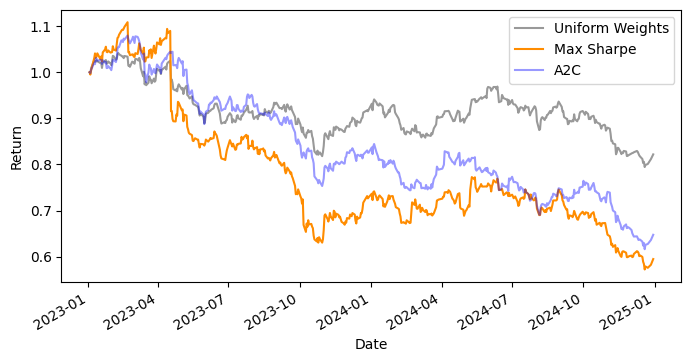

In [13]:
fig, ax = plt.subplots(figsize=(8,4))
uw_test_cum_returns.plot(ax=ax, color="black", alpha=.4);
max_sharpe_test_cum_returns.plot(ax=ax, color="darkorange");
TC_a2c_test_cum_returns.plot(ax=ax, color='blue', alpha=.4)
plt.legend(loc="best");
plt.xlabel('Date')
ax.set_ylabel("Return");
fig.savefig('results/TC_back_test_on_test_data.png')

### 7.5 Get the Portfolio Statistics

In [26]:
uw_test_returns_df = pd.DataFrame({
    'date': uw_test_returns.index, 
    'daily_return': uw_test_returns.values
}).reset_index(drop=True)

In [28]:
uw_test_returns = pd.DataFrame({
    'date': uw_test_returns.index, 
    'daily_return': uw_test_returns.values
}).reset_index(drop=True)

max_sharpe_test_returns = pd.DataFrame({
    'date': max_sharpe_test_returns.index, 
    'daily_return': max_sharpe_test_returns.values
}).reset_index(drop=True)

TC_a2c_test_daily_return['date'] = pd.to_datetime(TC_a2c_test_daily_return['date'])

In [30]:
def calculate_annual_return(returns):
    cumulative_return = np.prod(1 + returns) - 1  # Cumulative return for the entire period
    num_years = len(returns) / 252  # Assume 252 trading days per year
    annual_return = (1 + cumulative_return) ** (1 / num_years) - 1  # Annualized return
    return annual_return
def calculate_cumulative_return(returns):
    cumulative_return = np.prod(1 + returns) - 1
    return cumulative_return
def calculate_sharpe_ratio_entire_period(returns, risk_free_rate=0.0):
    mean_return = np.mean(returns)*252
    volatility = np.std(returns)*np.sqrt(252)
    sharpe_ratio = (mean_return - risk_free_rate) / volatility
    return sharpe_ratio
def calculate_max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    return max_drawdown
def calculate_annual_volatility(returns):
    daily_volatility = np.std(returns)  # Daily standard deviation
    annual_volatility = daily_volatility * np.sqrt(252)  # Annualize volatility
    return annual_volatility
def calculate_calmar_ratio(annual_return, max_drawdown):
    if max_drawdown == 0:  # Prevent division by zero
        return np.nan
    return annual_return / abs(max_drawdown)
def calculate_skewness(returns):
    return returns.skew()
def calculate_kurtosis(returns):
    return returns.kurt()

In [34]:
uw_test_returns_mod = uw_test_returns['daily_return']
max_sharpe_test_returns_mod = max_sharpe_test_returns['daily_return']
TC_a2c_test_daily_return_mod = TC_a2c_test_daily_return['daily_return']

for portfolio_name, returns in {
    "Uniform Weights": uw_test_returns_mod,
    "Maximum Sharpe": max_sharpe_test_returns_mod,
    "A2C Model": TC_a2c_test_daily_return_mod,
}.items():
    try:
        sharpe_ratio = calculate_sharpe_ratio_entire_period(returns)
        annual_return = calculate_annual_return(returns)
        max_drawdown = calculate_max_drawdown(returns)
        cumulative_return = calculate_cumulative_return(returns)
        annual_volatility = calculate_annual_volatility(returns)
        calmar_ratio = calculate_calmar_ratio(annual_return, max_drawdown)
        skewness = calculate_skewness(returns)
        kurt = calculate_kurtosis(returns)
        
        print(f"{portfolio_name} Portfolio:")
        print(f"  Annual Return: {annual_return:.6f}")
        print(f"  Cumulative Return: {cumulative_return:.6f}")
        print(f"  Annualized Sharpe Ratio: {sharpe_ratio:.6f}")
        print(f"  Maximum Drawdown: {max_drawdown:.6f}")
        print(f"  Annual Volatility: {annual_volatility:.6f}")
        print(f"  Calmar Ratio: {calmar_ratio:.6f}")
        print(f"  Skewness: {skewness:.6f}")
        print(f"  Kurtosis: {kurt:.6f}")
        print("-" * 50)
    except Exception as e:
        print(f"Error in {portfolio_name} Portfolio: {e}")

Uniform Weights Portfolio:
  Annual Return: -0.096556
  Cumulative Return: -0.178178
  Annualized Sharpe Ratio: -0.679575
  Maximum Drawdown: -0.237504
  Annual Volatility: 0.135785
  Calmar Ratio: -0.406543
  Skewness: -0.391634
  Kurtosis: 1.489601
--------------------------------------------------
Maximum Sharpe Portfolio:
  Annual Return: -0.235843
  Cumulative Return: -0.405372
  Annualized Sharpe Ratio: -1.042950
  Maximum Drawdown: -0.484098
  Annual Volatility: 0.231289
  Calmar Ratio: -0.487181
  Skewness: -2.845867
  Kurtosis: 30.403789
--------------------------------------------------
A2C Model Portfolio:
  Annual Return: -0.201546
  Cumulative Return: -0.352717
  Annualized Sharpe Ratio: -1.265439
  Maximum Drawdown: -0.429456
  Annual Volatility: 0.166778
  Calmar Ratio: -0.469305
  Skewness: -0.091682
  Kurtosis: 1.162043
--------------------------------------------------


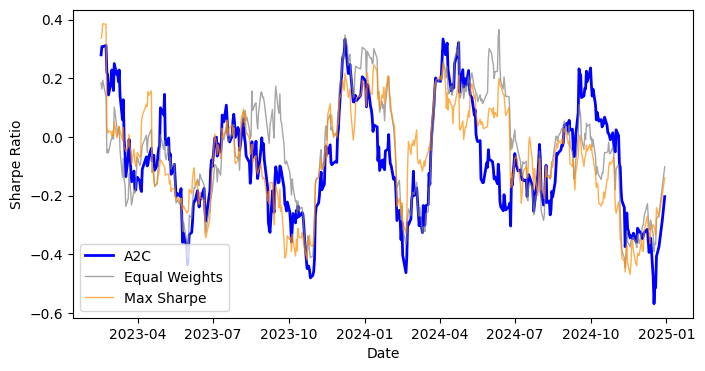

In [36]:
rolling_window = 30  # 30-day rolling window
risk_free_rate = 0  # Assuming a risk-free rate of 0

TC_a2c_test_daily_return['rolling_sharpe'] = (
    TC_a2c_test_daily_return['daily_return'].rolling(rolling_window).mean() - risk_free_rate
) / TC_a2c_test_daily_return['daily_return'].rolling(rolling_window).std()

uw_test_returns['rolling_sharpe'] = (
    uw_test_returns['daily_return'].rolling(rolling_window).mean() - risk_free_rate
) / uw_test_returns['daily_return'].rolling(rolling_window).std()

max_sharpe_test_returns['rolling_sharpe'] = (
    max_sharpe_test_returns['daily_return'].rolling(rolling_window).mean() - risk_free_rate
) / max_sharpe_test_returns['daily_return'].rolling(rolling_window).std()

plt.figure(figsize=(8, 4))

plt.plot(
    TC_a2c_test_daily_return['date'], 
    TC_a2c_test_daily_return['rolling_sharpe'], 
    label='A2C', 
    linewidth=2, 
    color='blue'
)
plt.plot(
    uw_test_returns['date'], 
    uw_test_returns['rolling_sharpe'], 
    label='Equal Weights', 
    linewidth=1, 
    color='gray', 
    alpha=0.7
)
plt.plot(
    max_sharpe_test_returns['date'], 
    max_sharpe_test_returns['rolling_sharpe'], 
    label='Max Sharpe', 
    linewidth=1, 
    color='darkorange', 
    alpha=0.7
)
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend()
#plt.grid()

plt.savefig('results/TC_rolling_sharpe_ratio.png', bbox_inches='tight')

plt.show()

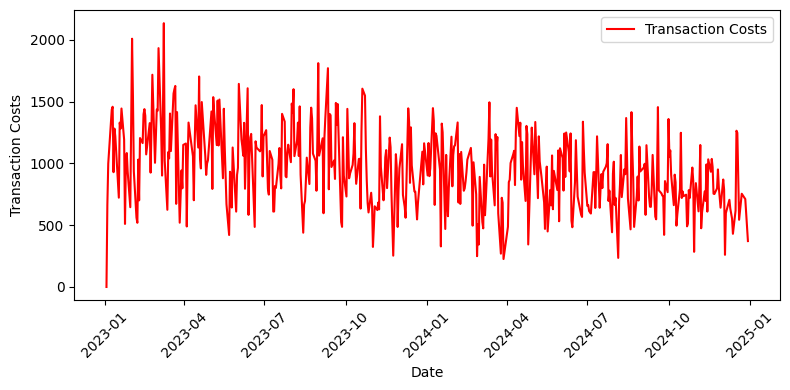

In [37]:
TC_a2c_test_transaction_costs['date']=pd.to_datetime(TC_a2c_test_transaction_costs['date'])
TC_a2c_test_transaction_costs.set_index('date', inplace=True)
plt.figure(figsize=(8, 4))

plt.plot(
    TC_a2c_test_transaction_costs['transaction_costs'], 
    color='red', 
    label='Transaction Costs'
)

plt.xlabel('Date')
plt.ylabel('Transaction Costs')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()

plt.savefig('results/TC_transaction_costs.png', bbox_inches='tight')

plt.show()

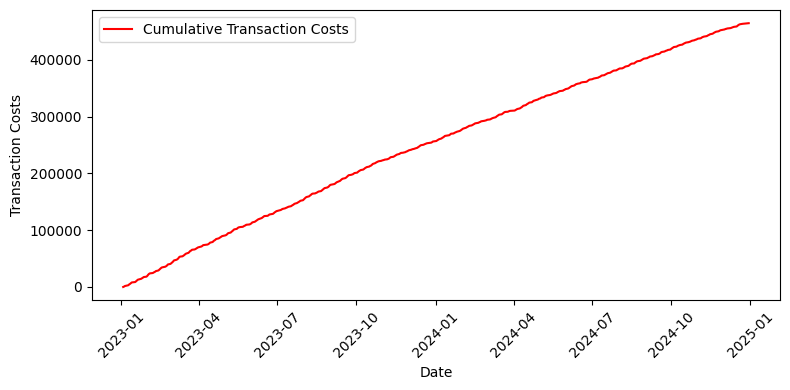

In [40]:
TC_a2c_test_transaction_costs['cumulative_transaction_costs'] = TC_a2c_test_transaction_costs['transaction_costs'].cumsum()

plt.figure(figsize=(8, 4))

plt.plot(
    TC_a2c_test_transaction_costs.index,  # Use the date index
    TC_a2c_test_transaction_costs['cumulative_transaction_costs'], 
    color='red', 
    label='Cumulative Transaction Costs'
)

plt.xlabel('Date')
plt.ylabel('Transaction Costs')
plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()

plt.savefig('results/TC_cumulative_transaction_costs.png', bbox_inches='tight')

plt.show()

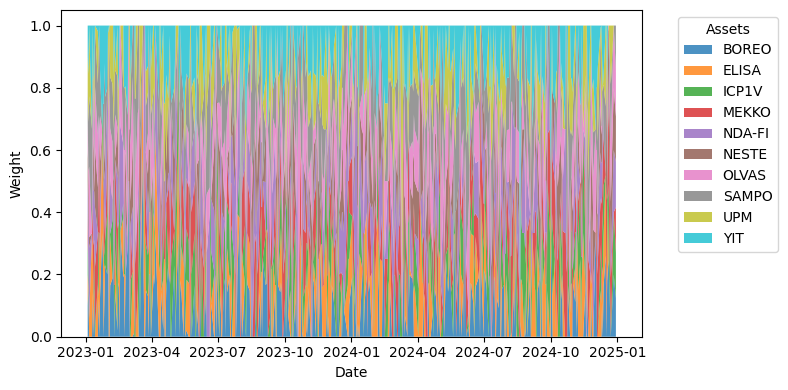

In [42]:
TC_a2c_test_weights['date'] = pd.to_datetime(TC_a2c_test_weights['date'])

TC_a2c_test_weights.set_index('date', inplace=True)

plt.figure(figsize=(8, 4))
plt.stackplot(
    TC_a2c_test_weights.index,  # Dates for x-axis
    TC_a2c_test_weights.T,  # Transposed weights for stackplot
    labels=TC_a2c_test_weights.columns,  # Asset names for legend
    alpha=0.8
)

plt.xlabel("Date")
plt.ylabel("Weight")
plt.legend(title="Assets", bbox_to_anchor=(1.05, 1), loc="upper left")
#plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig('results/TC_test_weights.png', bbox_inches='tight')
plt.show()

In [44]:
TC_a2c_test_weights

,BOREO,ELISA,ICP1V,MEKKO,NDA-FI,NESTE,OLVAS,SAMPO,UPM,YIT
date,,,,,,,,,,
2023-01-03,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2023-01-04,0.155392,0.000000,0.067646,0.000000,0.155392,0.155392,0.000000,0.155392,0.155392,0.155392
2023-01-05,0.000000,0.058634,0.000000,0.000000,0.226898,0.033773,0.226898,0.226898,0.226898,0.000000
2023-01-09,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333
2023-01-10,0.142857,0.142857,0.000000,0.142857,0.142857,0.000000,0.142857,0.142857,0.142857,0.000000
...,...,...,...,...,...,...,...,...,...,...
2024-12-19,0.220712,0.220712,0.000000,0.220712,0.220712,0.117150,0.000000,0.000000,0.000000,0.000000
2024-12-20,0.245389,0.000000,0.245389,0.245389,0.000000,0.245389,0.018444,0.000000,0.000000,0.000000
2024-12-23,0.000000,0.000000,0.000000,0.189243,0.054487,0.189243,0.189243,0.189243,0.188541,0.000000


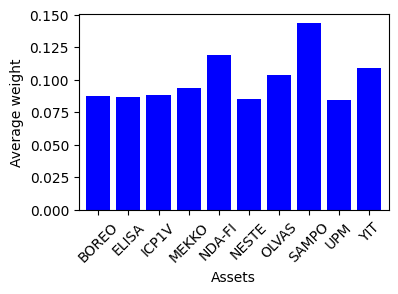

In [46]:
average_weights =TC_a2c_test_weights.mean()

average_weights_df = average_weights.reset_index()
average_weights_df.columns = ['Asset', 'Average Weight']
plt.figure(figsize=(4, 3))
average_weights.plot(kind='bar', color='blue', width=0.8)

plt.xlabel('Assets')
plt.ylabel('Average weight')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.savefig('results/TC_average_weights.png', bbox_inches='tight')
plt.show()

In [48]:
average_weights

BOREO     0.087156
ELISA     0.086659
ICP1V     0.087889
MEKKO     0.093807
NDA-FI    0.118633
NESTE     0.085188
OLVAS     0.103463
SAMPO     0.143352
UPM       0.084670
YIT       0.109183
dtype: float64